# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [19]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [3]:
! pip install unidecode
from unidecode import unidecode

You should consider upgrading via the '/home/ara/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [20]:
# YOUR CODE HERE
data['verse']=data['verse'].apply(unidecode)
data['verse'][18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [21]:
# YOUR CODE HERE
data['verse'] = data['verse'].drop_duplicates() # Remove duplicates

In [22]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [7]:
data.artist.value_counts()

Drake         1690
Ed Sheeran    1405
Kanye West     880
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [31]:
data.isna()
data.dropna(inplace=True)

In [32]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [33]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [78]:
vocab_size=len(tokenizer_drake.word_index)+len(tokenizer_ed.word_index)+len(tokenizer_kanye.word_index)

In [34]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [35]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [36]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.26% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [41]:
# YOUR CODE HERE
new_rows=[]
for row in data['verse']:
    row=tf.keras.preprocessing.text.text_to_word_sequence(row)
    new_rows.append(row)

[['ayy', 'woah', 'ayy', 'ayy', 'yeah'],
 ["i'm",
  "makin'",
  'a',
  'change',
  'today',
  'the',
  'liquor',
  'been',
  "takin'",
  'the',
  'pain',
  'away',
  'i',
  'heard',
  'you',
  'was',
  "givin'",
  'your',
  'chain',
  'away',
  "that's",
  'kinda',
  'like',
  "givin'",
  'your',
  'fame',
  'away',
  "what's",
  'wrong',
  'with',
  'you',
  'i',
  'sit',
  'in',
  'a',
  'box',
  'where',
  'the',
  'owners',
  'do',
  'a',
  'boss',
  'is',
  'a',
  'role',
  'that',
  "i've",
  'grown',
  'into',
  'i',
  'love',
  'you',
  'to',
  'death',
  'but',
  'i',
  'told',
  'you',
  'the',
  'truth'],
 ['i',
  "can't",
  'just',
  'be',
  'with',
  'you',
  'and',
  'only',
  'you',
  'yeah',
  'i',
  'got',
  'one',
  'virgil',
  'got',
  'one',
  'and',
  'that',
  'there',
  'is',
  'the',
  'only',
  'two',
  'man',
  'how',
  'many',
  'times',
  'have',
  'i',
  'shown',
  'improvement',
  'how',
  'many',
  'nights',
  'i',
  'been',
  'woah',
  "swervin'",
  'them

In [42]:
data['seq']=new_rows
data.head()

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

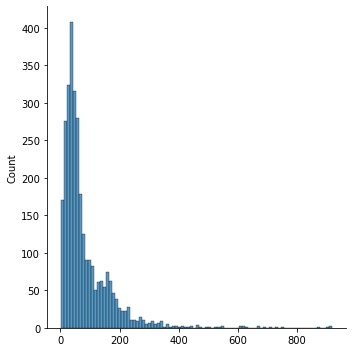

In [46]:
# YOUR CODE HERE
seq_lens=[len(row) for row in data['seq']]
sns.displot(data=seq_lens)

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [48]:
# YOUR CODE HERE
for row in data['seq']:
    row=row[0:300]

In [49]:
seq_lens=[len(row) for row in data['seq']]
max(len(seq_lens))

TypeError: 'int' object is not iterable

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [53]:
!pip install -U gensim

     |████████████████████████████████| 23.9 MB 32 kB/s  eta 0:00:01    |████▉                           | 3.6 MB 2.2 MB/s eta 0:00:10     |█████████▊                      | 7.3 MB 4.5 MB/s eta 0:00:04
You should consider upgrading via the '/home/ara/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [64]:
# YOUR CODE HERE
from gensim.models import Word2Vec

model = Word2Vec(sentences=data['seq'], vector_size=100, min_count=1, epochs=50)

In [71]:
my_dict = dict({})
for idx, key in enumerate(model.wv.key_to_index):
    my_dict[key] = model.wv[key]
my_dict

{'i': array([ 0.19607915,  0.7443383 , -0.21577474, -0.28331923, -0.22969201,
        -0.03095895,  1.6612705 , -0.01846771, -0.09389533,  0.82507265,
         1.5322394 ,  0.824387  , -0.57736665,  1.7508502 ,  0.9900615 ,
         0.14133924,  1.6205884 ,  1.4868673 , -1.7620625 ,  0.4262592 ,
         0.03491512, -0.49497724,  1.4857643 ,  0.32963517,  0.15908818,
        -1.0157753 ,  0.85278744,  0.29733884, -0.53230417,  0.51179147,
        -0.68607944, -0.49379963,  0.7810324 ,  0.07992902, -0.3535703 ,
        -0.4768785 , -0.24152096,  0.6095551 ,  0.3857897 ,  0.08968493,
        -1.6860985 ,  0.20544362,  0.731954  ,  0.37241662, -0.8906779 ,
         1.0751578 ,  0.34657127,  1.9509985 , -0.68474334,  0.3253325 ,
        -0.2663712 ,  0.18131794, -0.76533026, -0.7197077 ,  1.9889914 ,
        -1.675415  ,  0.19429566, -0.51665896, -0.5658517 ,  1.3535535 ,
         0.01426746, -0.4880197 , -1.6839916 ,  0.22336987,  1.3393146 ,
         0.01865481,  0.31401306, -1.2766944 ,

In [72]:
for row in data['seq']:
    for w in row:
        w=[ value for value in my_dict.values()]
        

ValueError: Length of values (12763) does not match length of index (3029)

In [59]:
# Check 
assert len(data['embed']) == len(data)

KeyError: 'embed'

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [ ]:
# YOUR CODE HERE

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [ ]:
# YOUR CODE HERE

👉 We train/test split the dataset below for you

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

In [73]:
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)

! rm data_lyrics_solution.pickle

--2021-06-29 16:33:55--  https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.218.29.170
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.218.29.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727513032 (694M) [application/octet-stream]
Saving to: ‘data_lyrics_solution.pickle’

data_lyrics_solutio 100%[===================>] 693.81M  5.17MB/s    in 2m 25s  

2021-06-29 16:36:22 (4.79 MB/s) - ‘data_lyrics_solution.pickle’ saved [727513032/727513032]



❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [ ]:
# YOUR CODE HERE
score_baseline=

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [85]:
# YOUR CODE HERE
from tensorflow.keras import layers, Sequential

embedding_size = 100

model = Sequential()
model.add(layers.Embedding(
input_dim=vocab_size+1,
output_dim=100,
mask_zero=True, 
))
model.add(layers.LSTM(20))
model.add(layers.Dense(10))
model.add(layers.Dense(3, activation="softmax"))
  

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [86]:
# YOUR CODE HERE
model.fit(X_train,y_train)

ValueError: in user code:

    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ara/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer lstm_1 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 300, 100, 100)


❓ **Plot the training and validation losses through training**

In [ ]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [ ]:
# YOUR CODE HERE

🧪 **Send your results below**

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()